In [1]:
import h5py
import math
import bisect
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import make_interp_spline
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
matplotlib.font_manager._rebuild()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
from IPython.display import set_matplotlib_formats
from IPython.display import display, Latex
set_matplotlib_formats('png', 'pdf')
import seaborn as sns

In [2]:

# Setze den Hintergrund von Figure und Axes auf #121212
plt.rcParams['figure.facecolor'] = '#121212'  # Hintergrund der gesamten Figur
plt.rcParams['axes.facecolor'] = '#121212'    # Hintergrund der Plot-Achsen

# Setze Schriftfarbe für Achsenlabels, Titel und Ticklabels auf #DDDDDD
plt.rcParams['text.color'] = '#DDDDDD'  
plt.rcParams['axes.labelcolor'] = '#DDDDDD'  
plt.rcParams['xtick.color'] = '#DDDDDD'  
plt.rcParams['ytick.color'] = '#DDDDDD'  

# Setze die Farbe der Rahmenlinien um den Plot (optional etwas dunkler)
plt.rcParams['axes.edgecolor'] = '#DDDDDD'  

background = '#121212'
mywhite = '#DDDDDD'

#core colors:
hellblau = '#56B4E9'
gruen = '#3D9B74'
sanftgelb = '#F2C94C'
koralle = '#F26B38'
rosa = '#F48FB1'

#backup colors
bahamagelb = '#F9C200'
chartreusegruen = '#A9E400'
weichmagenta = '#FF4081'
bordeaux = '#6A0D3D'

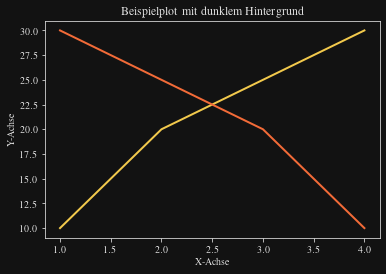

In [3]:
# Beispiel-Plot mit diesen Einstellungen
fig, ax = plt.subplots()
ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color=sanftgelb, linewidth=2)
ax.plot([4, 3, 2, 1], [10, 20, 25, 30], color=koralle, linewidth=2) 

ax.set_xlabel("X-Achse")
ax.set_ylabel("Y-Achse")
ax.set_title("Beispielplot mit dunklem Hintergrund")

plt.show()

In [4]:
class Data:
    def Slope(self, x, f):
            slope, intercept, r, p, std_err = stats.linregress(x, f)
            return slope
    
    def Intercept(self, x, f):
            slope, intercept, r, p, std_err = stats.linregress(x, f)
            return intercept
    
    def __init__(self, file):
        #self.savefigs = True
        self.x = np.array(file['BubbleScale/Variable'])
        self.real = np.array(file['BubbleScale/Real'])
        self.imag = np.array(file['BubbleScale/Imag'])
        
        self.uv = file['BubbleScale'].attrs['Upper Cutoff Bubble']
        self.ir = file['BubbleScale'].attrs['Lower Cutoff Bubble']
        self.b = file['BubbleScale'].attrs['b']
        self.vF = file['BubbleScale'].attrs['vF']
        self.prec = file['BubbleScale'].attrs['Precision']
        self.steps = file['BubbleScale'].attrs['Steps']
        self.extrap = file['BubbleScale'].attrs['extraPolate']
            
        self.krtilde = np.array(file['SelfEnergyScaling/krtilde'])
        self.radPos = np.array(file['SelfEnergyScaling/radPos'])
        self.radNeg = np.array(file['SelfEnergyScaling/radNeg'])
        self.kttilde = np.array(file['SelfEnergyScaling/kttilde'])
        self.tangPos = np.array(file['SelfEnergyScaling/tangPos'])
        self.tangNeg = np.array(file['SelfEnergyScaling/tangNeg'])
        
        self.APlus = file['SelfEnergyScaling'].attrs['APlus']
        self.AMinus = file['SelfEnergyScaling'].attrs['AMinus']
        
        self.krFit = np.array(file['SelfEnergyScaling/krFit'])
        self.radPosFit = np.array(file['SelfEnergyScaling/radPosFit'])
        self.radNegFit = np.array(file['SelfEnergyScaling/radNegFit'])
        self.ktFit = np.array(file['SelfEnergyScaling/ktFit'])
        self.tangPosFit = np.array(file['SelfEnergyScaling/tangPosFit'])
        self.tangNegFit = np.array(file['SelfEnergyScaling/tangNegFit'])
        
        self.radFreqs = np.array(file['imaginarySelfEnergy/freqsRad'])
        self.radSe1 = np.array(file['imaginarySelfEnergy/radSe1'])
        self.kr1 = file['imaginarySelfEnergy'].attrs['kr1']
        self.radSe2 = np.array(file['imaginarySelfEnergy/radSe2'])
        self.kr2 = file['imaginarySelfEnergy'].attrs['kr2']
        self.radSe3 = np.array(file['imaginarySelfEnergy/radSe3'])
        self.kr3 = file['imaginarySelfEnergy'].attrs['kr3']
        self.tangFreqs = np.array(file['imaginarySelfEnergy/freqsTang'])
        self.tangSe1 = np.array(file['imaginarySelfEnergy/tangSe1'])
        self.kt1 = file['imaginarySelfEnergy'].attrs['kt1']
        self.tangSe2 = np.array(file['imaginarySelfEnergy/tangSe2'])
        self.kt2 = file['imaginarySelfEnergy'].attrs['kt2']
        self.tangSe3 = np.array(file['imaginarySelfEnergy/tangSe3'])
        self.kt3 = file['imaginarySelfEnergy'].attrs['kt3']
        
        self.M = 1
        self.N = 2
    
        self.BPlus = self.Slope(self.krFit,self.radPosFit)
        self.BMinus = self.Slope(self.krFit,self.radNegFit)
        
        self.CPlus = self.Intercept(self.ktFit**2,self.tangPosFit/self.ktFit**2)
        self.CMinus = self.Intercept(self.ktFit**2,self.tangNegFit/self.ktFit**2)
        
        self.DPlus = self.Slope(self.ktFit**2,self.tangPosFit/self.ktFit**2)
        self.DMinus = self.Slope(self.ktFit**2,self.tangNegFit/self.ktFit**2)        

In [5]:
class Plotting(Data):
    def __init__(self,file):
        Data.__init__(self,file)    
    
    def bubbleScale(self):
        plt.plot(self.x,self.real,linewidth=2,color=hellblau, label = r'$\text{Re} I(x)$')
        plt.plot(self.x,self.imag,linewidth=2,color=rosa, label = r'$\text{Im} I(x)$')
        plt.xlabel(r'$x$',fontsize=20)
        plt.ylabel(r'$I(x)$',fontsize=20)
        plt.xlim([-3,3])
        plt.ylim([-0.4,1.0])
        plt.axvline(0.0,linewidth=1,color=mywhite,linestyle='--')
        plt.legend(fontsize=16)
        plt.savefig("bubble_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
        #plt.savefig('bubbleScale.png',bbox_inches="tight")
        plt.show()
        
    def radialScale(self):
        plt.plot(self.krtilde,self.radPos,linewidth=2,color= sanftgelb, label = r'$A^{(r)}_+$')
        plt.plot(self.krtilde,self.radNeg,linewidth=2,color= koralle, label = r'$A^{(r)}_-$')
        plt.xlabel(r'$\tilde{k}_r$',fontsize=20)
        plt.ylabel(r'$A^{(r)}_\pm(\tilde{k}_r)$',fontsize=20)
        plt.axvline(-1.0,linewidth=1,color=mywhite,linestyle='--')
        plt.axvline(1.0,linewidth=1,color=mywhite,linestyle='--')
        plt.xlim([-5.0,5.0])
        plt.legend(fontsize=16)
        plt.savefig("Ar4_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
        plt.show()
        
    def tangentialScale(self):
        plt.plot(self.kttilde,self.tangPos,linewidth=2,color=sanftgelb, label = r'$A^{(t)}_+$')
        plt.plot(self.kttilde,self.tangNeg,linewidth=2,color=koralle, label = r'$A^{(t)}_-$')
        plt.xlabel(r'$\tilde{k}_t$',fontsize=20)
        plt.ylabel(r'$A^{(t)}_\pm(\tilde{k}_t)$',fontsize=20)
        plt.xlim([0.0,5.0])
        plt.legend(fontsize=16)
        plt.savefig("At4_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
        plt.show()
        
    def radialSelfEnergy(self):
        plt.plot(self.radFreqs,self.M/self.N*self.radSe1,linewidth=2,color=sanftgelb,label= '$v k_r = $'+str(round(self.kr1,2)))
        plt.plot(self.radFreqs,self.M/self.N*self.radSe2,linewidth=2,color=koralle,label= '$v k_r = $'+str(round(self.kr2,2)))
        plt.plot(self.radFreqs,self.M/self.N*self.radSe3,linewidth=2,color=gruen,label= '$v k_r = $'+str(round(self.kr3,2)))
        plt.xlabel(r'$\omega$',fontsize=20)
        plt.ylabel(r'$Im\Sigma(k_r,k_t=0,\omega)$',fontsize=20)
        plt.xlim([-1,1])
        plt.ylim([-0.05,0.005])
        plt.legend(fontsize=16,loc=8)
        plt.savefig("imagRad_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
        plt.show()
        
    def tangentialSelfEnergy(self):
        plt.plot(self.tangFreqs,self.M/self.N*self.tangSe1,linewidth=2,color=sanftgelb,label= '$b k_t^4 = $'+str(round((self.kt1)**4,1)))
        plt.plot(self.tangFreqs,self.M/self.N*self.tangSe2,linewidth=2,color=koralle,label= '$b k_t^4 = $'+str(round((self.kt2)**4,1)))
        plt.plot(self.tangFreqs,self.M/self.N*self.tangSe3,linewidth=2,color=gruen,label= '$b k_t^4 = $'+str(round((self.kt3)**4,1)))
        plt.xlabel(r'$\omega$',fontsize=20)
        plt.ylabel(r'$Im\Sigma(k_r=0,k_t,\omega)$',fontsize=20)
        plt.xlim([-10,10])
        plt.legend(fontsize=16,loc=8)
        plt.savefig("imagTang_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
        plt.show()        
        
    def printCoefficients(self):
        display(Latex(f"$A_+ =$" + str(round(self.APlus,3))))
        display(Latex(f"$A_- =$" + str(round(self.AMinus,3))))
        display(Latex(f"$B_+ =$" + str(round(self.BPlus,3))))
        display(Latex(f"$B_- =$" + str(round(self.BMinus,3))))
        display(Latex(f"$C_+ =$" + str(round(self.CPlus,3))))
        display(Latex(f"$C_- =$" + str(round(self.CMinus,3))))
        display(Latex(f"$D_+ =$" + str(round(self.DPlus,3))))
        display(Latex(f"$D_- =$" + str(round(self.DMinus,3))))

In [5]:
foo = Plotting(h5py.File('quarticDispersion.h5','r'))

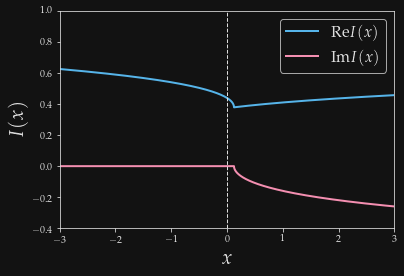

In [153]:
foo.bubbleScale()

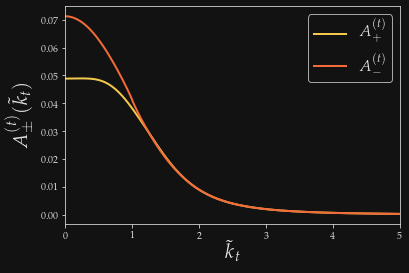

In [154]:
foo.tangentialScale()

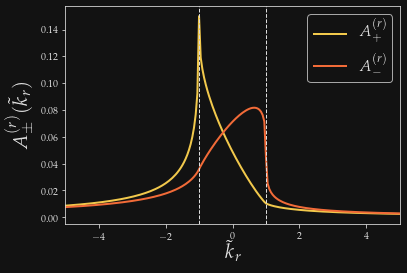

In [155]:
foo.radialScale()

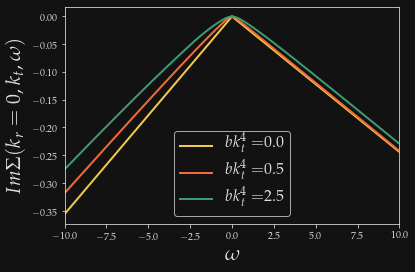

In [156]:
foo.tangentialSelfEnergy()

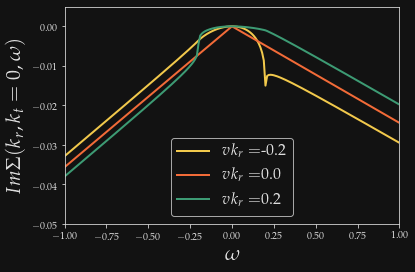

In [157]:
foo.radialSelfEnergy()

In [101]:
foo.printCoefficients()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

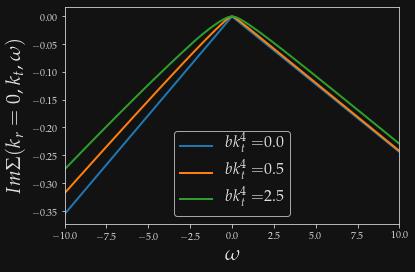

In [102]:
foo.tangentialSelfEnergy()

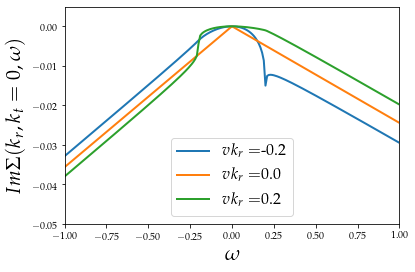

In [9]:
foo.radialSelfEnergy()

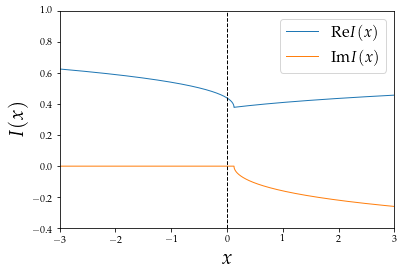

In [10]:
foo.bubbleScale()

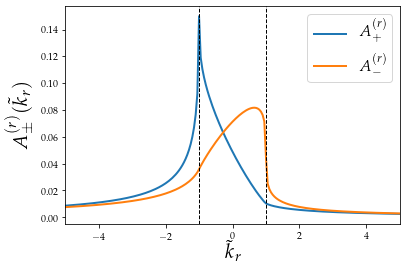

In [11]:
foo.radialScale()

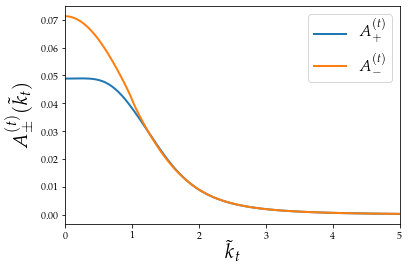

In [12]:
foo.tangentialScale()

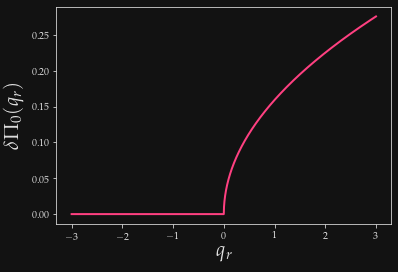

In [147]:
def f(x):
    if(x<0):
        return 0.0
    else:
        return 1.0/(2.0*math.pi)*math.sqrt(x)
f2 = np.vectorize(f)
x = np.linspace(-3, 3, 5000)
plt.plot(x, f2(x),linewidth=2,color=weichmagenta)
plt.xlabel(r'$q_r$',fontsize=20)
plt.ylabel(r'$\delta\Pi_0(q_r)$',fontsize=20)
plt.savefig("quadraticBubble_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
#plt.savefig('Graphics/flatBubble.pdf',bbox_inches="tight")
plt.show()

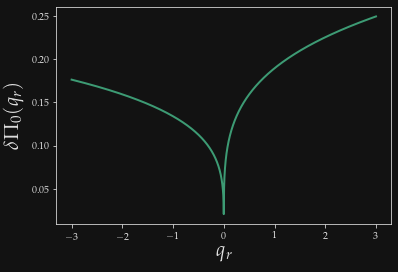

In [148]:
def f(qr,alf):
    if(qr<0):
        return abs(qr)**(1.0/alf)/(2*math.pi*(2)**(1.0/alf))*1/math.tan(math.pi/alf)
    else:
        return abs(qr)**(1.0/alf)/(2*math.pi*(2)**(1.0/alf))*1/math.sin(math.pi/alf)
f2 = np.vectorize(f)
x = np.linspace(-3, 3, 5000)
plt.plot(x, f2(x,4),linewidth=2,color=gruen)
plt.xlabel(r'$q_r$',fontsize=20)
plt.ylabel(r'$\delta\Pi_0(q_r)$',fontsize=20)
plt.savefig("quarticBubble_Dark.pdf", format="pdf", dpi=300, bbox_inches='tight',transparent=True)
#plt.savefig('Graphics/flatBubble.pdf',bbox_inches="tight")
plt.show()

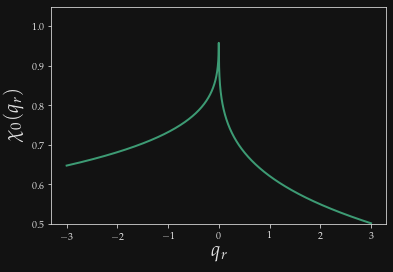

In [11]:
def f(qr,alf):
    if(qr<0):
        return -2*abs(qr)**(1.0/alf)/(2*math.pi*(2)**(1.0/alf))*1/math.tan(math.pi/alf)+1.0
    else:
        return -2*abs(qr)**(1.0/alf)/(2*math.pi*(2)**(1.0/alf))*1/math.sin(math.pi/alf)+1.0
f2 = np.vectorize(f)
x = np.linspace(-3, 3, 5000)
plt.plot(x, f2(x,4),linewidth=2,color=gruen)
plt.xlabel(r'$q_r$',fontsize=20)
plt.ylabel(r'$\chi_0(q_r)$',fontsize=20)
plt.ylim([0.5,1.05])
plt.savefig("quarticSuscep_Dark.pdf", format="pdf", dpi=300,bbox_inches='tight',transparent=True)
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


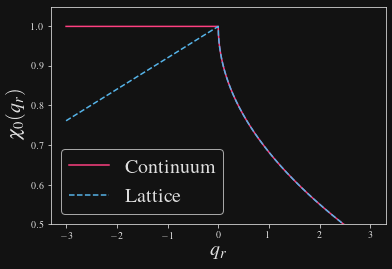

In [6]:
def f(x):
    if(x<0):
        return 0.0+1.0
    else:
        return -2/(2*math.pi)*math.sqrt(x)+1.0
f2 = np.vectorize(f)
x = np.linspace(-3, 3, 5000)
plt.plot(x, f2(x),label='Continuum',color=weichmagenta)

def g(x):
    if(x<0):
        return 1/(4*math.pi)*x+1.0
    else:
        return -2/(2*math.pi)*math.sqrt(x)+1.0
g2 = np.vectorize(g)
x = np.linspace(-3, 3, 5000)
plt.plot(x, g2(x),label='Lattice',color=hellblau,linestyle='dashed')


plt.xlabel(r'$q_r$',fontsize=20)
plt.ylabel(r'$\chi_0(q_r)$',fontsize=20)
plt.ylim([0.5,1.05])
plt.legend(fontsize=20)
#plt.savefig("quadraticSuscep_Dark.pdf", format="pdf", dpi=300,bbox_inches='tight',transparent=True)
plt.show()

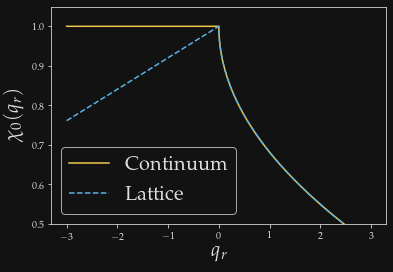

In [4]:
def f(x):
    if(x<0):
        return 0.0+1.0
    else:
        return -2/(2*math.pi)*math.sqrt(x)+1.0
f2 = np.vectorize(f)
x = np.linspace(-3, 3, 5000)
plt.plot(x, f2(x),label='Continuum',color=sanftgelb)

def g(x):
    if(x<0):
        return 1/(4*math.pi)*x+1.0
    else:
        return -2/(2*math.pi)*math.sqrt(x)+1.0
g2 = np.vectorize(g)
x = np.linspace(-3, 3, 5000)
plt.plot(x, g2(x),label='Lattice',color=hellblau,linestyle='dashed')


plt.xlabel(r'$q_r$',fontsize=20)
plt.ylabel(r'$\chi_0(q_r)$',fontsize=20)
plt.ylim([0.5,1.05])
plt.legend(fontsize=20)
plt.savefig("quadraticSuscep_Dark.pdf", format="pdf", dpi=300,bbox_inches='tight',transparent=True)
plt.show()

In [15]:
import matplotlib.pyplot as plt

print(plt.rcParams["font.family"])  
print(plt.rcParams["legend.fontsize"])  
print(plt.rcParams["legend.edgecolor"])


['serif']
medium
0.8


In [20]:
import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name())

IBM Plex Sans
TeX Gyre Schola
Baekmuk Dotum
drmtcbx6
drmdozittc12
Quattrocento Sans
Chivo
drmuibx24
Noto Sans
Tlwg Typist
DejaVu Serif
drmdozbx7
Courier 10 Pitch
QTBlimpo
LobsterTwo
QTLetterGoth
TeX Gyre DejaVu Math
Cyklop
Noto Sans Mono
Gentium Book Basic
drmdozuibx10
Go
Merriweather
Luxi Serif
Almendra
Khmer OS Content
Open Sans
Fandol Braille
Noto Sans Mono
Open Sans
drmdozb14
drmui12
QTDingBits
NewComputerModern
QTMilitary
Eczar
FreeSans
Spectral
rblmi
STIX Two Text
Bitstream Charter
Old Standard
drminf6
Fira Sans
Antykwa Torunska
drmit14
ocrb6
Overlock
STEP
Noto Sans
Noto Sans
Noto Sans
Josefin Sans
drmfigs7
Latin Modern Mono Light
QTEurotype
drmdoz10
Noto Serif
Fira Mono
Linux Libertine Mono O 
Noto Sans
Carlito
Antykwa Poltawskiego
drmdozl17
Latin Modern Mono Prop Light
Antykwa Poltawskiego Light
CMU Bright
STIX Two Math
Nunito
Raleway
Droid Serif
Poppins
IBM Plex Serif
Chivo
Latin Modern Mono Prop Light
Bandal
drml10
Libre Franklin
drmdoztc10
Marcellus SC
Berenis ADF Pro SC
TeX

RuntimeError: In FT2Font: Can not load face.